## ISMIP6 Tool of Observing Model Ranges using Clustering

Eleanor M. Byrne

### Introduction to the Tool
#### <i>The Purpose</i>

### Modules/Packages

In [1]:
# import models
%matplotlib inline
import os
os.environ["OMP_NUM_THREADS"] = '1'
import glob
import pandas as pd
import netCDF4 as nc
from netCDF4 import Dataset
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
from IPython.display import display
from typing import List
from pathlib import Path
import re
import xarray as xr
from scipy.cluster.hierarchy import linkage, dendrogram
# from plots_graphs.basemap import Base_temp_VUW_PISM, cartopy_basemap
from sklearn.cluster import KMeans
import matplotlib.colors as mcolors
import seaborn as sns
from tabulate import tabulate
from sklearn.preprocessing import StandardScaler
import ipywidgets as widgets
# from utils.file_upload import file_upload
# from utils.files_types import folder_dir

### ISMIP6 Terminology

For the ISMIP6 data it consists of a few different experiments that are used for ice sheet simulations. 

| Header 1 | Header 2 | Header 3 |
|----------|----------|----------|
| Row 1, Col 1 | Row 1, Col 2 | Row 1, Col 3 |
| Row 2, Col 1 | Row 2, Col 2 | Row 2, Col 3 |
| Row 3, Col 1 | Row 3, Col 2 | Row 3, Col 3 |

### The NetCDF Files
<h5 id="C5">[5]</h5>

#### Group ISMIP6 Data by Variable and Experiment Type
This is for grouping the files based on the processes and the experiment type. Make sure that the user already has ISMIP6 downloaded, from globus personal, on their computer and set as the directory/path.

An ISMIP6 file name is constructed as <i>variable_IS_GROUP_MODEL_EXP.nc</i>:

| <h4>File name convention</h4> | <h4>Description</h4> |
|----------|----------|
| <b>variable</b> | The variable is the forcing that is being observed. They tend to contain 3 dimentsions (x,y,t) but sometimes time will not be in the nc file components depending on the variable|
|<b>IS</b>|The ice sheet of either AIS or GIS (Antarctic or Greenland)|
|<b>Group</b>|Research group acronym|
|<b>Model</b>|Model acronym|
|<b>EXP</b>|experiment name|

In [2]:
# set the path/directory where the files are located
path = "C:/Users/Margo/OneDrive/Documents/ISMIP_ResearchThesis/models/"

# filter through the files 
'''
Format of compiling/filtering the different variables, group, model, and exp types is <variable>_<IS>_<GROUP>_<MODEL>_<EXP>.nc
'''
def filter_files(directory, variable, IS_type, exp_type):
    # insert the variable name (ex: lithk) and the exp type (ex: ctrl_proj) that will be visualized
    # GIS is Greenland 
    pattern = re.compile(fr'{variable}_{IS_type}_\w+_\w+_{exp_type}\.nc', re.IGNORECASE)
    filtered_files = []
    for root, dirs, files in os.walk(directory):
        # Check if '___ is in any of the subdirectory names
        if exp_type in root:
            for filename in files:
                # if pattern/filter matches the files found in the path showcase/bind them
                if pattern.match(filename):
                    filtered_files.append(os.path.join(root, filename))
    return filtered_files

In [5]:

''' Widget section 

Question: What is a Widget?

Answer: They are interactive graphical user interface (GUIs) that can be used to display components like sliders, text boxes, etc

'''
# Create widgets for user input
variable_widget = widgets.Combobox(
    value='',
    options = ['lithk', 'orog', 'topg', 'hfgeoubed', 'acabf', 'libmassbfgr', 'libmassbffl', 'dlithkdt', 'xvelsurf', 'yvelsurf', 'zvelsurf', 'xvelbase', 
               'yvelbase', 'zvelbase', 'zvelbase', 'xvelmean', 'yvelmean', 'litemptop', 'litempbotgr', 'litempbotfl', 'strbasemag', 'licalvf', 'lifmassbf',
               'sftgif', 'sftgrf', 'sftflf'],
    description='Variable:',
    placeholder='Enter variable name (e.g., lithk)'
)

IS_widget = widgets.Combobox(
    value ='',
    options = ['GIS', 'AIS'],
    description = 'IS',
    placeholder='Enter IS name (GIS or AIS)'
)

exp_type_widget = widgets.Combobox(
    value='',
    options = ['ctrl', 'asmb', 'historical', 'ctrl_proj'],
    description='Exp Type:',
    placeholder='Enter experiment type (e.g., ctrl_proj)'
)


# Function to display filtered files based on widget inputs
def on_button_click(b):
    variable = variable_widget.value
    IS_type = IS_widget.value
    exp_type = exp_type_widget.value
    filtered_files = filter_files(path, variable, IS_type, exp_type)
    
    # Store the filtered file paths for use in the next section
    global file_paths
    file_paths = filtered_files
    
    # Clear previous outputs
    output.clear_output()
    
    with output:
        # Print the filtered file paths
        if filtered_files:
            print("Filtered Files:")
            for file_path in filtered_files:
                print(file_path.replace('\\', '/'))
        else:
            print("No files found matching the criteria.")

# Create a button to trigger the file filtering
filter_button = widgets.Button(
    description="Filter Files", 
    disabled=False, 
    button_style='success', 
    tooltip='Click me',
)

# Define the button click event handler
filter_button.on_click(on_button_click)

# Create an output widget to display text
output = widgets.Output()

# Display the widgets and button
display(variable_widget, IS_widget, exp_type_widget, filter_button, output)

Combobox(value='', description='Variable:', options=('lithk', 'orog', 'topg', 'hfgeoubed', 'acabf', 'libmassbf…

Combobox(value='', description='IS', options=('GIS', 'AIS'), placeholder='Enter IS name (GIS or AIS)')

Combobox(value='', description='Exp Type:', options=('ctrl', 'asmb', 'historical', 'ctrl_proj'), placeholder='…

Button(button_style='success', description='Filter Files', style=ButtonStyle(), tooltip='Click me')

Output()

#### <i>Creating a personalized list of ISMIP and Cleaning the Data</i>

In [ ]:
# path = 'C:/Users/Margo/OneDrive/Documents/ISMIP_ResearchThesis/models/AWI/ISSM1/ctrl_proj/lithk_GIS_AWI_ISSM1_ctrl_proj.nc'
# dataset = xr.open_dataset(path)

# # Print the time coordinates for the 'lithk' variable
# time_coords = dataset['lithk'].coords['time']
# print(time_coords)

In [7]:

# Function to extract data variables and comments
def data_variables(file_path, variable_name, time_indices):
    with xr.open_dataset(file_path) as data:
        # Extract the specified variable
        field_var = data[variable_name]
        
        # Extract model group information from attributes
        model_group = data.attrs.get('comment', 'No comment')
        
        # Check if 'time' dimension exists and handle accordingly
        if 'time' in field_var.dims:
            time_values = data.coords['time'].values
            if time_indices is not None:
                field_var = field_var.isel(time=time_indices)
            else:
                field_var = field_var.isel(time=slice(None))  # Select all time slices
        else:
            time_values = None
            
        return field_var, model_group, time_values

def extract_variables(file_paths, variable_name, time_indices):
    # create an empty list 
    extracted_data = [] 

    for file_path in file_paths:
        try:
            field_var, model_group, time_values = data_variables(file_path, variable_name, time_indices)
            extracted_data.append((field_var, model_group, time_values))
        except Exception as e:
            print(f"Error processing {file_path}: {e}")
        
    return extracted_data

def aggregate_data(extracted_data, variable_name):
    all_data = []
    for field_var, model_group, time_values in extracted_data:
        # Convert field_var to DataFrame
        field_var_df = field_var.to_dataframe().reset_index()
        
        # If time values exist, add them to the DataFrame
        if time_values is not None:
            # Create a DataFrame for time values and repeat the first time value for each row
            time_df = pd.DataFrame({'Time': [time_values[0]] * len(field_var_df)})
            # Concatenate time DataFrame with the field variable DataFrame
            field_var_df = pd.concat([time_df, field_var_df], axis=1)
        # Add model_group to the DataFrame
        field_var_df['Model Group'] = model_group
    
        # Append to the list of all data
        all_data.append(field_var_df)
        
    # Concatenate all DataFrames
    aggregated_data = pd.concat(all_data, ignore_index=True)

    # Convert NaNs to zeros
    aggregated_data.fillna(0, inplace=True)

    # Filter out rows where variable is zero across all models
    filtered_data = aggregated_data[aggregated_data[variable_name] != 0]


    # Record the cleaned DataFrame
    return filtered_data, variable_name

In [9]:
'''
Widget Section: 

This consists of the variable data which contains the data across greenland and the time that will be observed

'''
variable_extraction_widget = widgets.Combobox(
    value='',
    options=['lithk', 'orog', 'topg', 'hfgeoubed', 'acabf', 'libmassbfgr', 'libmassbffl', 'dlithkdt', 'xvelsurf', 'yvelsurf', 'zvelsurf', 'xvelbase', 
               'yvelbase', 'zvelbase', 'zvelbase', 'xvelmean', 'yvelmean', 'litemptop', 'litempbotgr', 'litempbotfl', 'strbasemag', 'licalvf', 'lifmassbf',
               'sftgif', 'sftgrf', 'sftflf'],
    description= 'Variable:',
    placeholder='Enter variable name (e.g., lithk)'
)

# Widget for selecting a year (using IntSlider)
year_widget = widgets.BoundedIntText(
    value=0,
    min=0,
    max=86, # 85 is the max year, 2101
    step=1,
    description='Year Index:',
    continuous_update=False
)

# Create a button to trigger the data extraction and display
extraction_button = widgets.Button(
    description="Extract and Display Data",
    disabled=False,
    button_style='success',
    tooltip='Click me'
)

def on_extraction_button_click(b):
    variable_name = variable_extraction_widget.value 
    # return the variable name 
    year = year_widget.value
    # Extract variable data
    try:
        # Convert year to index
        time_indices = [year]
        
        # Extract variables
        extracted_data = extract_variables(file_paths, variable_name, time_indices)
        
        # Aggregate data
        
        global filtered_data, returned_variable_name
        
        filtered_data, returned_variable_name = aggregate_data(extracted_data, variable_name)
        
        with extraction_output:
            extraction_output.clear_output()
            if not filtered_data.empty:
                print(filtered_data)
            else:
                print("No data available for the selected criteria.")
    
    except Exception as e:
        with extraction_output:
            extraction_output.clear_output()
            print(f"An error occurred: {e}")
            
    return variable_name, returned_variable_name

# Create an output widget to display text
extraction_output = widgets.Output()

# Attach event handler to button
extraction_button.on_click(on_extraction_button_click)

# Display widgets and button
display(variable_extraction_widget, year_widget, extraction_button, extraction_output)

Combobox(value='', description='Variable:', options=('lithk', 'orog', 'topg', 'hfgeoubed', 'acabf', 'libmassbf…

BoundedIntText(value=0, description='Year Index:', max=86)

Button(button_style='success', description='Extract and Display Data', style=ButtonStyle(), tooltip='Click me'…

Output()

In [10]:
filtered_data

,Time,time,y,x,lon,lat,lithk,Model Group
10605,2016-01-01 00:00:00,2016-01-01 00:00:00,31.0,158.0,-43.782974,60.236876,23.928774,"AWI, ISSM1"
10606,2016-01-01 00:00:00,2016-01-01 00:00:00,31.0,159.0,-43.696072,60.235925,28.058300,"AWI, ISSM1"
10607,2016-01-01 00:00:00,2016-01-01 00:00:00,31.0,160.0,-43.609177,60.234909,34.677792,"AWI, ISSM1"
10608,2016-01-01 00:00:00,2016-01-01 00:00:00,31.0,161.0,-43.522288,60.233827,46.750973,"AWI, ISSM1"
10609,2016-01-01 00:00:00,2016-01-01 00:00:00,31.0,162.0,-43.435406,60.232680,49.023556,"AWI, ISSM1"
...,...,...,...,...,...,...,...,...
2909843,2016-01-01 00:00:00,2016-01-01 00:00:00,-670000.0,205000.0,-27.987453,83.538586,0.113780,"NCAR, CISM"
2909844,2016-01-01 00:00:00,2016-01-01 00:00:00,-670000.0,210000.0,-27.597296,83.524973,0.951184,"NCAR, CISM"
2909845,2016-01-01 00:00:00,2016-01-01 00:00:00,-670000.0,215000.0,-27.208797,83.511062,1.504367,"NCAR, CISM"
2909846,2016-01-01 00:00:00,2016-01-01 00:00:00,-670000.0,220000.0,-26.821981,83.496854,1.097017,"NCAR, CISM"


#### Finding the Averages of the Models

In [ ]:
'''
0. Revisualize it as columns and rows 
1. Replace the NaNs as zero
2. Find the columns that have zero in it (doesn't have to be every single one)
    2a. delete/eliminate column - remove all from the huge matrix 
3. Record these columns with their index 
'''

In [11]:
'''
Computing the Stats of the data

Mean, Standard Deviation, Min, and Max of the variable data 

'''

stats_data_list = []
grouped = filtered_data.groupby('Model Group')
    
for model_group, group_data in grouped:
    stats = {
            'Model Group': model_group,
            f'{returned_variable_name} Mean': group_data[returned_variable_name].mean(),  # Mean of the variable
            f'{returned_variable_name} Std': group_data[returned_variable_name].std(),   # Standard deviation of the variable
            f'{returned_variable_name} Max': group_data[returned_variable_name].max(),   # Max of the variable
            f'{returned_variable_name} Min': group_data[returned_variable_name].min()    # Min of the variable
        }
    stats_data_list.append(stats)
        
# Create DataFrame from stats data list
stats_df = pd.DataFrame(stats_data_list)
print(stats_df)

             Model Group   lithk Mean   lithk Std    lithk Max     lithk Min
0             AWI, ISSM1  1761.396560  856.715742  3281.667725  1.000000e+00
1             AWI, ISSM2  1755.458016  862.417978  3281.403320  1.000000e+00
2             AWI, ISSM3  1747.671972  869.031492  3281.411865  1.000000e+00
3          BGC, BISICLES  1718.955688  893.297458  3359.331922  8.934317e-09
4             GSFC, ISSM  1648.968356  928.615631  3311.590088  1.135286e-07
5   ILTS_PIK, SICOPOLIS1  1649.102924  919.037662  3328.096436  1.137391e-04
6   ILTS_PIK, SICOPOLIS2  1652.423240  916.097146  3328.087158  4.038518e-05
7         IMAU, IMAUICE1  1716.663110  835.183263  3266.458984  2.100662e-03
8         IMAU, IMAUICE2  1764.684866  819.721624  3325.912598  1.776162e-01
9              JPL, ISSM  1699.308381  849.525527  3242.108501  4.055699e-08
10        JPL, ISSMPALEO  1395.845928  921.320786  3009.936607  1.439397e-08
11          LSCE, GRISLI  1790.995014  843.286060  3390.002038  5.123665e-03

<Figure size 1200x800 with 0 Axes>

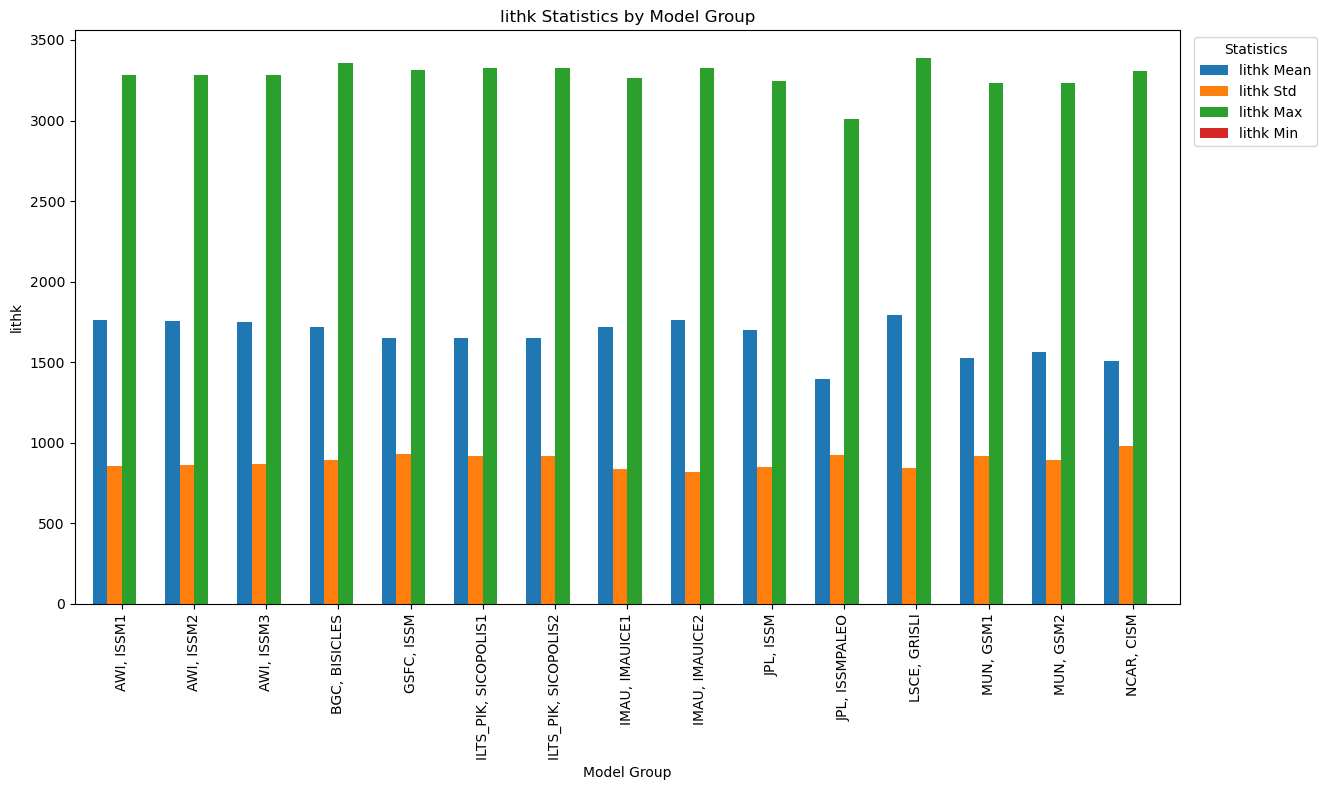

In [13]:
''' Using different plots to visualize the stats of the models

Sources used: 
https://www.geeksforgeeks.org/how-to-plot-a-dataframe-using-pandas/ 
https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.plot.html
https://saturncloud.io/blog/legend-outside-the-plot-in-python-matplotlib/
'''

# Set up the figure size
plt.figure(figsize=(12, 8))

# Plot using Pandas plot method
stats_df.plot(x='Model Group', kind='bar', width=0.8, figsize=(12, 8))

# Set labels and title
plt.xlabel('Model Group')
plt.ylabel(f'{returned_variable_name}')
plt.title(f'{returned_variable_name} Statistics by Model Group')

# Rotate x-axis labels for better visibility
plt.xticks(rotation=90)

# Show plot
plt.tight_layout()
# plotting the legend and its position on the plot
plt.legend(title='Statistics', bbox_to_anchor=(1.13, 1), loc='upper right')
plt.show()


### The Elbow Method and its Utilization

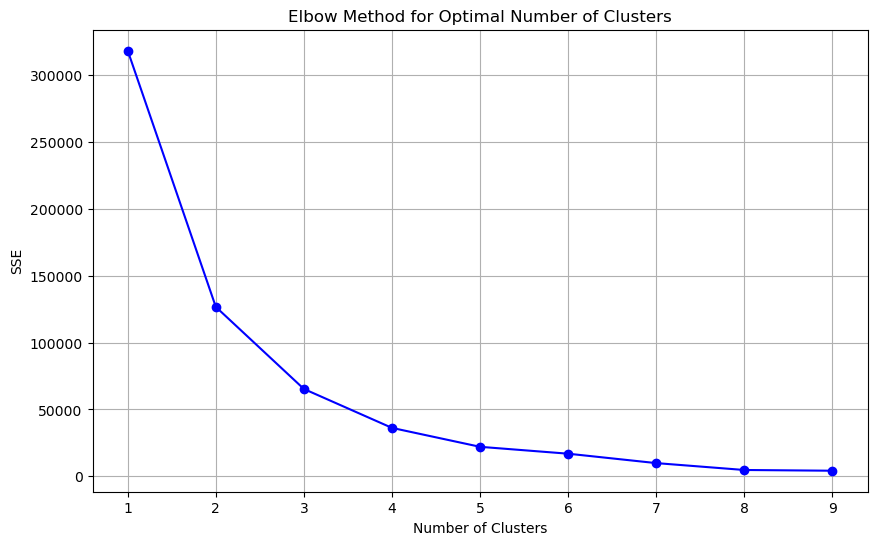

In [15]:
'''
Source Used: 
https://www.geeksforgeeks.org/elbow-method-for-optimal-value-of-k-in-kmeans/
https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html
https://stackoverflow.com/questions/19197715/scikit-learn-k-means-elbow-criterion
'''

# prepare the data for clustering 
stats_x = stats_df[[f'{returned_variable_name} Mean', f'{returned_variable_name} Std', 
                    f'{returned_variable_name} Max', f'{returned_variable_name} Min']]

# Sum of Squared Errors or WCSS (Within-Cluster Sum of Squares)
    # Same meaning 
sse = []

for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, init='random', n_init=10, random_state=42)  # Initialize KMeans with desired parameters
    kmeans.fit(stats_x)
    sse.append(kmeans.inertia_)
    
# Plot the elbow curve
plt.figure(figsize=(10, 6))
plt.plot(range(1, 10), sse, marker='o', linestyle='-', color='b')
plt.xlabel('Number of Clusters')
plt.ylabel('SSE')
plt.title('Elbow Method for Optimal Number of Clusters')
plt.xticks(range(1, 10))
plt.grid(True)
plt.show()

### The K-means Clustering
#### <i>How does this work?</i>

In [17]:
'''
Sources Used:
https://www.geeksforgeeks.org/elbow-method-for-optimal-value-of-k-in-kmeans/
https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html
https://chatgpt.com for understanding how to impliment centroids
https://matplotlib.org/stable/api/legend_api.html
'''

# From the elbow method choose the k = _ depending the value 
optimal_k = 4 

# Prepare the data for clustering and use stats_x variable 
kmeans = KMeans(
    n_clusters=optimal_k,   # Number of clusters to form
    init='k-means++',           # Method for initialization: 'random' or 'k-means++'
    n_init=25,               # Number of times to run KMeans with different centroid seeds
    max_iter=300,            # Maximum number of iterations for each single run
    verbose=True,            # Verbosity mode: True for detailed output, False for none
    random_state=42,         # Seed for random number generation for reproducibility
    algorithm='elkan'        # Algorithm to use: 'lloyd', or 'elkan'
)

# Compute cluster centers and predict cluster index for each sample
clusters = kmeans.fit_predict(stats_x)

# Add the cluster labels to the DataFrame
stats_df['Cluster'] = clusters

# Display the DataFrame with cluster labels
print(stats_df)

# Save the centroids, they are the center of the cluster 
centroids = kmeans.cluster_centers_

Initialization complete
Iteration 0, inertia 49510.14441858609
Iteration 1, inertia 36182.131351161894
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 48991.73666562887
Iteration 1, inertia 36182.131351161894
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 76237.06019249168
Iteration 1, inertia 42073.59843760953
Iteration 2, inertia 36182.131351161894
Converged at iteration 2: strict convergence.
Initialization complete
Iteration 0, inertia 118707.26839005445
Iteration 1, inertia 59110.20308681913
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 56701.98242408413
Iteration 1, inertia 36182.131351161894
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 86795.91123339212
Iteration 1, inertia 52166.71727819231
Iteration 2, inertia 48764.255060890464
Converged at iteration 2: strict convergence.
Initialization complete
Iter

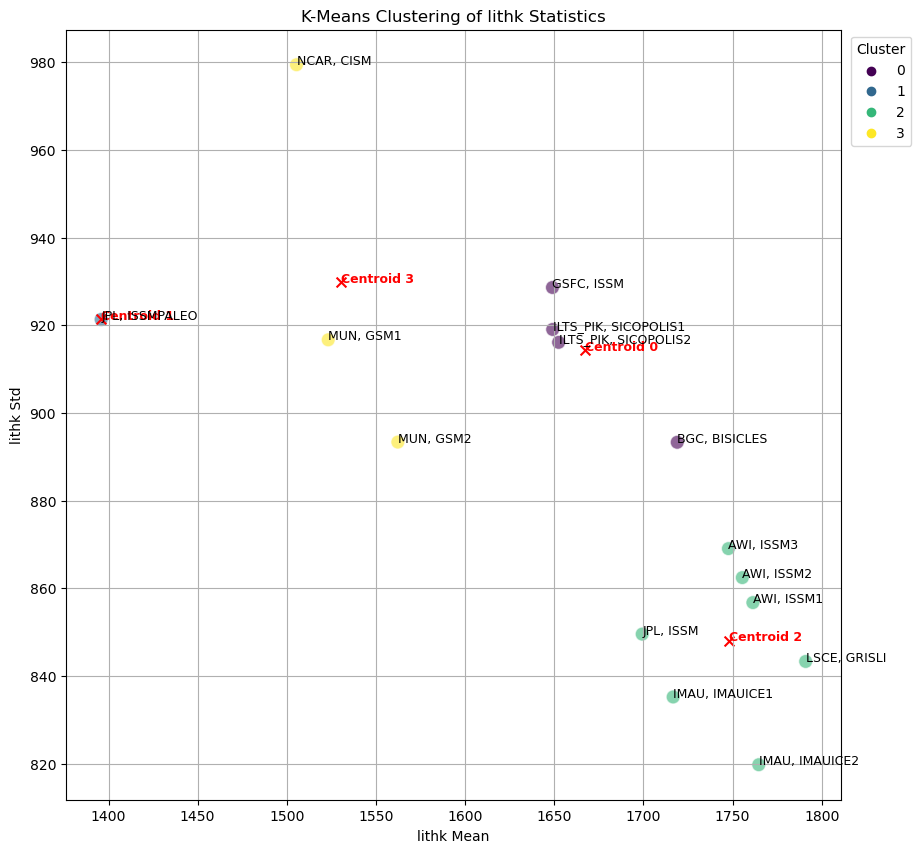

In [21]:
'''
Now that the centroids are found the next step is to visualize the clusters
Centroids are the central points of each cluster
They represent the average position of all the points in a cluster in the feature space

'''

# Set up the figure size
plt.figure(figsize=(10, 10))

# Create a scatter plot with seaborn
sns.scatterplot(x=f'{returned_variable_name} Mean', y=f'{returned_variable_name} Std', hue='Cluster', palette='viridis', data=stats_df, s=100, alpha=0.6, legend='full')

# Plot the centroids
for i, centroid in enumerate(centroids):
    plt.scatter(centroid[0], centroid[1], marker='x', s=50, c='red')
    plt.text(centroid[0], centroid[1], f'Centroid {i}', fontsize=9, color='red', weight='bold')

# Add labels for each point
for i in range(len(stats_df)):
    plt.text(stats_df[f'{returned_variable_name} Mean'][i], stats_df[f'{returned_variable_name} Std'][i], stats_df['Model Group'][i], fontsize=9)

# Set labels and title
plt.xlabel(f'{returned_variable_name} Mean')
plt.ylabel(f'{returned_variable_name} Std')
plt.title(f'K-Means Clustering of {returned_variable_name} Statistics')
plt.legend(title='Cluster',  bbox_to_anchor=(1.1, 1), loc='upper right')
plt.grid(True)
plt.show()

### Implimenting Hierarchical clustering

In [ ]:
# def plot_hierarchical_clusters(compressed_data_list, method='ward'):
#     """
#     Performs hierarchical clustering on the compressed data and plots the resulting dendrogram.
    
#     Args:
#         compressed_data_list (list): A list of tuples containing source model and compressed ice thickness data.
#         method (str): The linkage method to use. Default is 'ward'.
#     """
#     fig, ax = plt.subplots(figsize=(10, 6))
    
#     for model_group, compressed_data in compressed_data_list:
#         # Perform hierarchical clustering using the specified method
#         linked = linkage(compressed_data.reshape(-1, 1), method=method)
        
#         # Plot the dendrogram
#         dendrogram(linked,
#                    orientation='top',
#                    distance_sort='descending',
#                    show_leaf_counts=True,
#                    ax=ax,
#                    label=source_model)
    
#     # Set the title of the plot indicating the clustering method used
#     ax.set_title(f'Hierarchical Clustering Dendrogram ({method} method)')
    
#     # Label the x-axis
#     ax.set_xlabel('Sample Index')
    
#     # Label the y-axis
#     ax.set_ylabel('Distance')
    
#     # Add a legend to the plot to identify the source models
#     ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1))
    
#     # Display the plot
#     plt.show()

# # Define the number of clusters based on the elbow method (if applicable)
# optimal_clusters = 4  # Replace this with the actual optimal number from the elbow method

# # Call plot_hierarchical_clusters function with the compressed data
# plot_hierarchical_clusters(result, method='ward')

In [ ]:
# cartopy_basemap()

### Adding in the Data
Now that the basemap has been created, it is time to add the data that needs to be plotted

In [ ]:
# # base_temp_VUW_PISM
# lon_VP = base_temp_VUW_PISM['lon'][:]
# lat_VP = base_temp_VUW_PISM['lat'][:]
# base_VP = base_temp_VUW_PISM['litempbotgr'][0:]
# label_VP = 'Temp beneath grounded ice sheet'

# # base_temp_UAF_PISM2
# lon_UP = base_temp_UAF_PISM2['lon'][:]
# lat_UP = base_temp_UAF_PISM2['lat'][:]
# base_UP = base_temp_UAF_PISM2['litempbotgr'][0:]
# label_UP = 'Temp beneath grounded ice sheet'

# # base_temp_UCIJPL_ISSM1
# lon_UI = base_temp_UCIJPL_ISSM1['lon'][:]
# lat_UI = base_temp_UCIJPL_ISSM1['lat'][:]
# base_UI = base_temp_UCIJPL_ISSM1['litempbotgr'][0:]
# label_UI = 'Temp beneath grounded ice sheet'

# # base_temp_UCIJPL_ISSM2
# lon_UI2 =  base_temp_UCIJPL_ISSM2['lon'][:]
# lat_UI2 =  base_temp_UCIJPL_ISSM2['lat'][:]
# base_UI2 =  base_temp_UCIJPL_ISSM2['litempbotgr'][0:]
# label_UI2 = 'Temp beneath grounded ice sheet'

# # bed_VUW_PISM
# lon_b_VP =  bed_VUW_PISM['lon'][:]
# lat_b_VP =  bed_VUW_PISM['lat'][:]
# base_b_VP =  bed_VUW_PISM['topg'][0:]
# label_b_VP = 'Bedrock elevation'

# # iceT_VUW_PISM
# lon_iT_VP =  iceT_VUW_PISM['lon'][:]
# lat_iT_VP =  iceT_VUW_PISM['lat'][:]
# base_iT_VP =  iceT_VUW_PISM['lithk'][0:]

In [ ]:
# cartopy_basemap(lon_VP, lat_VP, base_VP, label_VP)

In [ ]:
# cartopy_basemap(lon_UP, lat_UP, base_UP, label_UP)

In [ ]:
# cartopy_basemap(lon_UI, lat_UI, base_UI)

In [ ]:
# cartopy_basemap(lon_UI2, lat_UI2, base_UI2, label_UI2)

In [ ]:
# cartopy_basemap(lon_iT_VP, lat_iT_VP, base_iT_VP)

In [ ]:
# cartopy_basemap(lon_b_VP, lat_b_VP, base_b_VP, label_b_VP)

### Processing Data

### Plotting and Graphs 

### Elbow Method

### K-Means Clustering

### Results 

### References/Sources
Used for mentioning papers, github, and other sites to find code sources or additonal information

* <h5 id="C1">[1]</h5><a href="https://www.climate-cryosphere.org/wiki/index.php?title=ISMIP6-Projections-Antarctica ">Cryosphere Climate Antartica</a>  Used for terminology and understanding the functionanilty of the ISMIP6 projections.
* <h5 id="C2">[2]</h5> <a href="https://www.climate-cryosphere.org/wiki/index.php?title=ISMIP6-Projections-Greenland">Cryosphere Climate Greenland</a>: Used for terminology and understanding the functionanilty of the ISMIP6 projections.
* <h5 id="C3">[3]</h5> <a href="https://chat.openai.com/auth/login?iss=https%3A%2F%2Fauth0.openai.com%2F">ChatGPT</a>: Used for converting matlab code into usable python code and additional code edits. 
* <h5 id="C4">[4]</h5> <a href="https://github.com/hgoelzer-ismip6/ismip6-gris-analysis">ISMIP6 Analysis Github</a>: Scripts for the plotting of ISMIP6 Greenland projections created by hgeolzer. Matlab scripts were converted into python by Eleanor M. Byrne using ChatGPT and other resources found. 
* <h5 id="C5">[5]</h5> <a href="https://realpython.com/working-with-files-in-python/">Working with Files in Python</a>: Website with helpful tips of viewing files. 
* <h5 id="C6">[6]</h5> <a href="https://theghub.org/groups/ismip6/wiki/MainPage">ISMIP6 Ghub</a>:Webpage on Ghub. 
* <h5 id="C7">[7]</h5> <a href="https://www.pism.io/docs/manual/practical-usage/ismip6.html#tab-ismip6-variables">ISMIP6_Term</a>
* <h5 id="C8">[8]</h5> <a href="https://scitools.org.uk/cartopy/docs/latest/matplotlib/intro.html#adding-data-to-the-map">Cartopy</a> Used this for creating a base map of Greenland to plot the data found. 